In [1]:
from bs4 import BeautifulSoup

In [2]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

исходные данные - сохраненные html страницы результатов поиска с сайта avito - 13 штук. Искали дачные участки в подмосковье с домиками из бруса. 

In [3]:
import os
files = os.listdir()
htmls=[]
for i in files:
    if i.endswith('html'):
        htmls.append(i)
print(htmls[:-3])

['dacha-brus1.html', 'dacha-brus11.html', 'dacha-brus12.html', 'dacha-brus13.html', 'dacha-brus14.html', 'dacha-brus2.html', 'dacha-brus3.html', 'dacha-brus4.html', 'dacha-brus5.html', 'dacha-brus6.html', 'dacha-brus7.html', 'dacha-brus8.html', 'dacha-brus9.html']


In [4]:

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import pandas as pd

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#иногда указано расстояние до ближаешего метро, а не километраж и шоссе, причем в другом формате:
# сначала метро, а потом киломтераж. приходится в двух случаях по разному обрабатывать текст

area1=[]
house1=[]
prices1=[]
distance1=[]
direction=[]
for file in htmls:
    soup = BeautifulSoup(open(file, encoding="utf8")) 
    prices = soup.find_all('div',{'class':'price' })  #разбить по тегам div у которых класс = price
    area = soup.find_all('div', {'class':'param site_area'})
    house = soup.find_all('div', {'class':'param house_area'})
    distance = soup.find_all('div', {'class':'param location fader'})
    
    #список площадей участков, сотки
    
    for i in range (1,len(area)):
        a=area[i].text
        a=a.split('участок ')[1]
        a=a.split(' сот.')[0]
        a=float(a)
        area1.append(a)
    #список площадей домов, м2  
    
    for i in range (1,len(house)):
        a=house[i].text
        a=a.split(' м²')[0]
        a=float(a)
        house1.append(a)
    #список цен
    for i in range (1,len(prices)):
        a=prices[i].text
        a=a.split('р.')[0]
        prices1.append(a)
    # расстояния, км и направление
    for i in range (1,len(distance)):
        a=distance[i].text
        if a[3].isdigit():
            b=a.split(' км')[0]
            #иногда после километража нет данных о шоссе
            try:
                c=a.split(' км,')[1]
            except IndexError:
                c='нет данных'
            distance1.append(float(b))
            direction.append(c)
        else:
            d=a.split('  ')[4].split(' км')[0]
            if '+' in d:
                d1=float(d.split('+')[0])
            if d.endswith(' м'):
                d1=float(d.split(' м')[0])/1000
            if d.endswith(' '):
                d1=float(d)
            else:
                d1=d
            distance1.append(d1)
            e=str('Метро' + a.split('  ')[3])
            direction.append(e)   

In [6]:
prices[2]

<div class="price"> <p>
  1 900 000 р. <span class="nw"> </span>
</p>
</div>

In [7]:
for p in prices1:
    p = p.split('р.')[0]

In [8]:
areas=pd.Series(area1, name='площадь участка')
house_areas=pd.Series(house1, name='площадь дома')
prices=pd.Series(prices1, name='цена')
distance=pd.Series(distance1, name='расстояние')
direction=pd.Series(direction, name='направление')

In [9]:
df=pd.concat([areas, house_areas, prices, distance, direction], axis=1)

In [10]:
#вытаскиваем цену как число из текста вида \n 1 600 000 р. \n\n
func = lambda x: x.replace(" ", "") #убираем пробелы
func2 = lambda x: [int(s) for s in x.split() if s.isdigit()] #вытаскиваем список (1число) чисел из каждой ячейки
func3= lambda x: x[0]
pr2=df['цена'].apply(str).apply(func).apply(func2)
intprice = []
for price in pr2:
    if len(price)==1:
        intprice.append(price[0])
    else:
        intprice.append(0)
newprices=pd.Series(intprice, name='цена')

In [11]:
df2=pd.concat([areas, house_areas, newprices/1000, distance, direction], axis=1)

In [12]:
sotkaprice= df2['цена']/df['площадь участка']
df2.insert(loc=len(df2.columns), column='цена за сотку', value=sotkaprice) 
# loc - номер столбца, после которого нужно вставить данный Series
# мы указали len(df.columns), чтобы вставить его в самом конце

Таблица готова! теперь посмотрим на данные

In [13]:
df2

площадь участка  площадь дома      цена расстояние  \
0                 6.0          75.0  1600.000         37   
1                10.0          73.0  1789.500         95   
2                10.0          92.0  1800.000         85   
3                 8.5         132.0  2989.000         51   
4                 8.0         120.0  7000.000         45   
5                 8.0          50.0   100.000         92   
6                 7.0          20.0   120.000         92   
7                 4.0          20.0   150.000        138   
8                 7.6          20.0   199.000        130   
9                 4.0          20.0   199.999          5   
10                4.0          20.0   199.999          5   
11                5.0          20.0   210.000        105   
12                6.0          22.0   220.000         14   
13                6.0          30.0   260.000         10   
14                4.0          36.0   270.000          3   
15                6.0          20.0   295.000          5   
16                6.0          50.0   300.000        152   
17               12.0          30.0   300.000        139   
18                7.0          25.0   300.000        110   
19                6.0          50.0   300.000        140   
20               12.0          24.0   300.000         35   
21                8.0          48.0   300.000         15   
22                6.0          25.0   300.000         87   
23                8.0          20.0   320.000         60   
24                6.0          80.0   320.000        150   
25                6.0          20.0   330.000          5   
26                6.0          20.0   350.000        130   
27                4.0          45.0   350.000         10   
28               12.0          50.0   350.000         90   
29                7.0          70.0   350.000        160   
...               ...           ...       ...        ...   
1432              6.0          36.0   850.000         47   
1433              8.0         100.0  2900.000        115   
1434             14.0          36.0  1200.000        100   
1435              6.0          55.0  1100.000         28   
1436              5.0          29.6   800.000         65   
1437              6.0          70.0  1600.000         50   
1438              6.0          95.0  1290.000         40   
1439              6.0          60.0  1700.000         85   
1440              8.0         100.0  2850.000         80   
1441              6.0          76.0  1350.000         82   
1442              6.0          60.0  1000.000        101   
1443             11.0          30.0   650.000         65   
1444              7.0          30.0  1400.000         25   
1445              6.0          40.0  1490.000         50   
1446             15.0          65.0  6000.000         40   
1447              6.0          38.0  1100.000         35   
1448              6.0          39.0  2050.000         38   
1449              1.0          32.0   389.431         20   
1450              8.0         130.0  6530.000          1   
1451              9.0          75.0     0.000         30   
1452              7.0          32.0     0.000          7   
1453              8.1          56.0   475.000        100   
1454              6.0          44.0   985.000         60   
1455              8.5          90.0  1300.000         80   
1456              8.1          80.0  2500.000         47   
1457              6.7          45.0   760.000        150   
1458              6.0          50.0  1200.000         10   
1459             10.0         120.0  2950.000         80   
1460              6.0         100.0  2100.000         40   
1461              6.0          80.0  2100.000         55   

                   направление  цена за сотку  
0          Егорьевское шоссе       266.666667  
1              Минское шоссе       178.950000  
2              Минское шоссе       180.000000  
3          Дмитровское шоссе       351.647059  
4          Новорижское шоссе       875.000000

In [14]:
#убираем выбросы и объявления с указанием метро вместо шоссе
dfred=df2[df2['цена'] < 5000].dropna()
dfred=dfred[~dfred['направление'].str.contains('Метро')]
dfred.tail()

площадь участка  площадь дома    цена расстояние  \
1457              6.7          45.0   760.0        150   
1458              6.0          50.0  1200.0         10   
1459             10.0         120.0  2950.0         80   
1460              6.0         100.0  2100.0         40   
1461              6.0          80.0  2100.0         55   

                 направление  цена за сотку  
1457       Каширское шоссе       113.432836  
1458     Новорижское шоссе       200.000000  
1459   Волоколамское шоссе       295.000000  
1460        Киевское шоссе       350.000000  
1461       Рязанское шоссе       350.000000

Посмотрим на распределения различных параметров

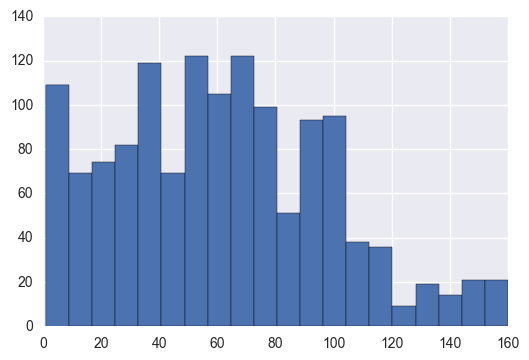

In [66]:
(dfred['расстояние']).hist(bins=20)
plt.show()

In [498]:
(dfred['цена']).hist(bins=30)
plt.show()
#стоит обратить внимание на завышенное количество объявлений с круглой стоимсотью - каждые 0.5 миллиона

In [499]:
(dfred[dfred['площадь дома'] < 200])['площадь дома'].hist(bins=20)
plt.show()

In [74]:
#выбор конкретного шоссе
dfkash=dfred[dfred['направление'].str.contains('Каширское шоссе')]

посмотрим на scatter-plot всех параметров

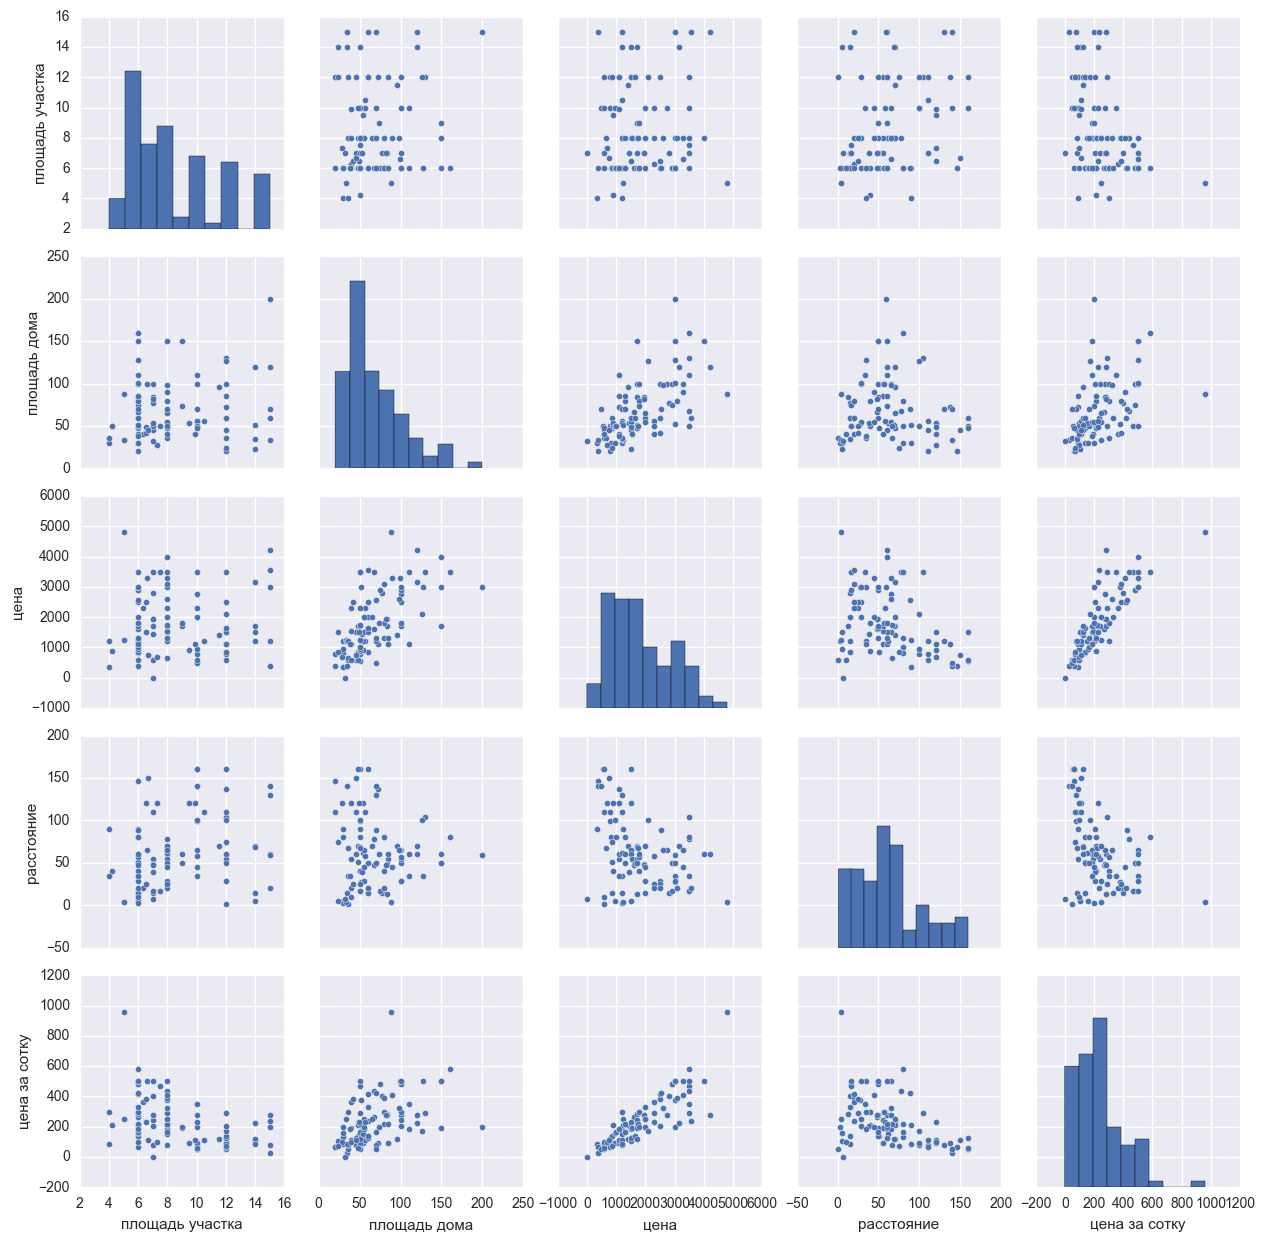

In [139]:
sns_plot = sns.pairplot(dfkash)

Посмотрим более детально на scatter plot отдельных параметров для каширского шоссе

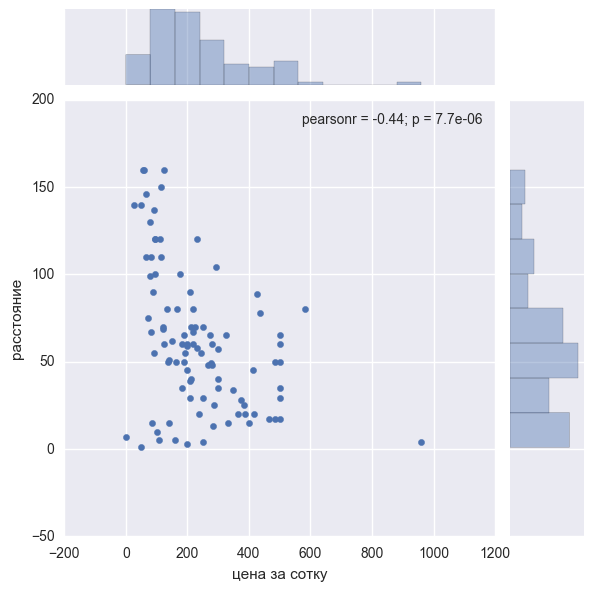

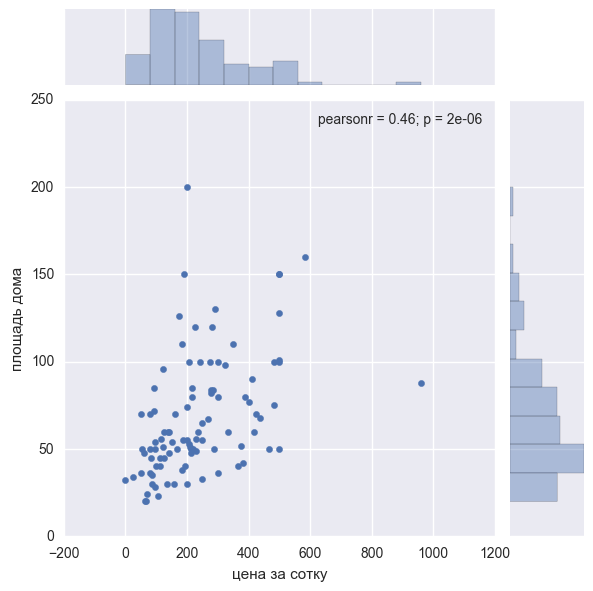

In [519]:
sns.jointplot(dfkash['цена за сотку'], dfkash['расстояние'])
sns.jointplot(dfkash['цена за сотку'], dfkash['площадь дома'])

Теперь взглянем на боксплоты распределения цен по разным направлениям, для того чтобы глазами оценить вклад в вариабельность для этой категориальной переменной.

In [155]:
sns.boxplot(y="направление", x="цена за сотку", data=dfred[dfred['цена за сотку']<800], orient="h")
plt.show()

In [72]:
dfs1=dfred[dfred['направление'].str.contains('Каширское шоссе')]
dfs2=dfred[dfred['направление'].str.contains('Варшавское шоссе')]
dfs3=dfred[dfred['направление'].str.contains('Калужское шоссе')]
dfs4=dfred[dfred['направление'].str.contains('Киевское шоссе')]
dfs5=dfred[dfred['направление'].str.contains('Минское шоссе')]
dfs8=dfred[dfred['направление'].str.contains('Можайское шоссе')]
dfs6=dfred[dfred['направление'].str.contains('Волоколамское шоссе')]
dfs7=dfred[dfred['направление'].str.contains('Пятницкое шоссе')]
frames = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs8, dfs6, dfs7]

result = pd.concat(frames)
len(dfs3)

68

Теперь рассмотрим только соседние направлений, при этом уберем выбросы по цене.
Видно, что при перечислении направлений по их терроиториальному порядку проявляется более плаваня зависимость распределения цены от направления

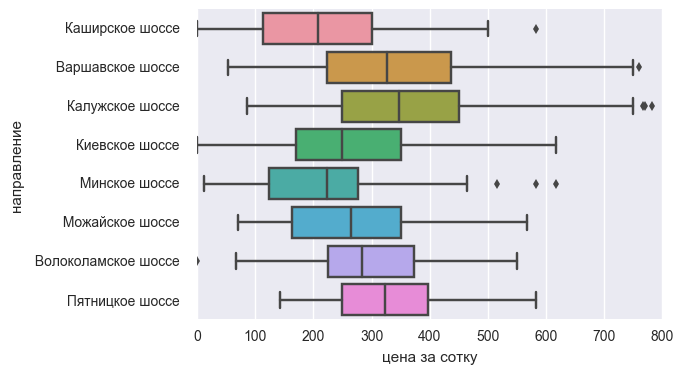

In [701]:
sns.boxplot(y="направление", x="цена за сотку", data=result[result['цена за сотку']<800], orient="h")

In [147]:
#посмотрим на статистику по выбранным направлениям
frames = [dfs2, dfs3, dfs6, dfs7, dfs8]
dflast = pd.concat(frames)
dflast.describe()

площадь участка  площадь дома         цена  цена за сотку
count       180.000000    180.000000   180.000000     180.000000
mean          7.396111     67.309444  2278.055550     331.976058
std           2.760908     29.965609  1019.020285     162.757256
min           4.000000     20.000000     0.000000       0.000000
25%           6.000000     47.000000  1500.000000     220.000000
50%           6.000000     60.000000  2250.000000     310.378788
75%           8.000000     82.500000  2990.000000     425.892857
max          20.000000    200.000000  4900.000000     783.333333

Посмотим, будет ли разница при построении модели с использованием всех данных и с использованием только данных по определенным направлениям
Для начала применим самую грубую модель - множесвтенную линейную регрессию

In [490]:
#Расчет цены по трем параметрам на основе данных 4х направлений
rast = dflast['расстояние'].tolist()
dompl=dflast['площадь дома'].tolist()
uchpl=dflast['площадь участка'].tolist()
X=np.matrix([rast, dompl, uchpl])
y=dflast['цена'].tolist()
X=X.transpose(1,0)

clf = Ridge(alpha=100)
clf.fit(X, y)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [91]:
#Расчет цены по трем параметрам на основе данных всех направлений
rast =  dfred['расстояние'].tolist()
dompl=dfred['площадь дома'].tolist()
uchpl=dfred['площадь участка'].tolist()
X=np.matrix([rast, dompl, uchpl])
y=dfred['цена'].tolist()
X=X.transpose(1,0)

clf = Ridge(alpha=1000.0)
clf.fit(X, y)


[ 1186.16452686]
0.273985831808


C:\Users\Stanislav\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


по коэфициенту R^2 видно, что лучше все-таки использовать данные выбранного и смежных направлений, иначе возрастает ошибка. Впрочем такое распределеие цен не удивительно - известно, что западное направление ценится меньше из-за направления ветра и соответсвтенно промышленных выхлопов 


Однако наш коэфициент R^2 выглядит мягкоговоря неубедительно.
попробуем использовать нелинейную модель регрессии.
Полиномиальная регрессия черевата переобучением, поэтому воспользуемся ridge-регуляризацией, для того чтобы этого избежать

In [453]:
rast = dflast['расстояние'].tolist()
dompl=dflast['площадь дома'].tolist()
uchpl=dflast['площадь участка'].tolist()
X=np.matrix([rast, dompl, uchpl])
y=dflast['цена'].tolist()
X=X.transpose(1,0)
i=10
model = make_pipeline(PolynomialFeatures(2), Ridge(alpha=i))
model.fit(X,y)

scr=model.score(X,y)
print(scr)

0.451294189363


Теперь подойдем к построению моделей более аккуратно: разобъем датасет на обучающую и тестовую выборку для возможности проверки модели кросс-валидацией.

In [472]:
#перемешаем датасет и сбросим нумерацию индексов
dfshufl = dflast.sample(frac=1).reset_index(drop=True)
dftrain=dfshufl[0:150]
dftest=dfshufl[151:180]

In [481]:
rast = dftrain['расстояние'].tolist()
dompl=dftrain['площадь дома'].tolist()
uchpl=dftrain['площадь участка'].tolist()
X=np.matrix([rast, dompl, uchpl])
y=dftrain['цена'].tolist()
X=X.transpose(1,0)
i=2
model = make_pipeline(PolynomialFeatures(2), Ridge(alpha=i))
model.fit(X,y)

scr=model.score(X,y)
print("коэфициент корреляции:",scr)
rast = dftest['расстояние'].tolist()
dompl=dftest['площадь дома'].tolist()
uchpl=dftest['площадь участка'].tolist()
price=dftest['цена'].tolist()
X=np.matrix([rast, dompl, uchpl])
X=X.transpose(1,0)
pricecalc=model.predict(X)

dftest=dfshufl[151:180]
error= abs(dftest['цена']-pricecalc)/dftest['цена']
dftest.insert(loc=len(dftest.columns), column='рассчитанная цена', value=pricecalc) 
dftest.insert(loc=len(dftest.columns), column='ошибка', value=error)
dftest.describe()

коэфициент корреляции: 0.412438430963


площадь участка  площадь дома         цена  цена за сотку  \
count        29.000000     29.000000    29.000000      29.000000   
mean          7.248276     73.724138  2486.551724     369.860429   
std           2.484613     32.434436   970.582579     161.615458   
min           5.000000     20.000000   850.000000      70.833333   
25%           6.000000     55.000000  1500.000000     270.000000   
50%           6.000000     75.000000  2600.000000     358.333333   
75%           8.000000     92.000000  3200.000000     466.666667   
max          13.000000    160.000000  4300.000000     770.000000   

       рассчитанная цена     ошибка  
count          29.000000  29.000000  
mean         2386.793652   0.215021  
std           716.968144   0.212109  
min           840.681267   0.001159  
25%          1757.225731   0.051676  
50%          2446.227457   0.139169  
75%          2944.693821   0.315068  
max          3562.526096   0.811655

In [489]:
#посчитаем стоимость нашего участка на калужском шоссе, зная его параметры: 
model.predict(np.matrix([79, 40, 6]))

array([ 1136.58476119])

Критерием оценки качества модели было медианное значение относительной ошибки расчета цены для тестовой выборки. Из всех полиномиальных моделей наименьшую ошибку показал полином второй степени и параметр регуляризации равный 2 (впрочем в данном конкретном случае ощутимого вклада регуляризация не дала). 

Стоит принимать во внимание природу изначальных данных - цена объявления на сайте еще не означает цену сделки, это так сказать верхняя половина стакана, если проводить аналогию с рынком ценных бумаг. Естественно предложение всегда завышено по сравнению с реальными ценами сделок. Более того, из гистограммы распределения цен по характерным пикам(1.5, 2, 2.5, 3, 3.5 млн) видно, что продавцы очень любят округлить стоимость с точностью до полумиллиона, надо полагать в сторону завышения. Так что результат расчета нашей модели точно можно считать завышенным и при указании стоимости в объявлении ее нужно снизить.

Код и графики для готносительной ошибки от степени полинома и зависимости ошибки от коэфициента регуляризации  приведены ниже.

Комментарий:
Я понимаю, что тут можное еще многое сделать. Например вместо выбора направлений можно было для начала кластеризовать все объявления, а потом понять, к какому кластеру относится наш участок. И далее строить модель, используя объявления из этого кластера. Так возможно нужно было более детально проанализировать выбросы - предобработка и аккуратная очистка данных может играть очень большую роль.
Знаю, что для разбиения на тестовую и обучающую выборки, кросс-валидации и поиска оптимальных параметров модели в sklearn.model_selection есть такие инструменты как train_test_split, cross_val_score и GridSearchCV, но пока до их изучения пока руки не доходили. Поэтому тут сделал это так сказать вручную.

Прошу прощения за корявость стиля кода, в ближайшем будущем все буду делать по pep8

In [474]:
scores=[]
medians=[]
means=[]
rast = dftrain['расстояние'].tolist()
dompl=dftrain['площадь дома'].tolist()
uchpl=dftrain['площадь участка'].tolist()
X=np.matrix([rast, dompl, uchpl])
y=dftrain['цена'].tolist()
X=X.transpose(1,0)

rast = dftest['расстояние'].tolist()
dompl=dftest['площадь дома'].tolist()
uchpl=dftest['площадь участка'].tolist()
price=dftest['цена'].tolist()
XT=np.matrix([rast, dompl, uchpl])
XT=XT.transpose(1,0)

degrees=range(1,10)

for j in degrees:
    model = make_pipeline(PolynomialFeatures(j), Ridge(alpha=0))
    model.fit(X,y)
    scr=model.score(X,y)
    pricecalc=model.predict(XT)
    dftest=dfshufl[151:180]
    error= abs(dftest['цена']-pricecalc)/dftest['цена'] 
    coef=model.steps[1][1].coef_
    medians.append(error.median())
    means.append(error.mean())
    scores.append(scr)
plt.plot(degrees, medians, 'ro')
plt.show()

In [479]:
scores=[]
medians=[]
means=[]
rast = dftrain['расстояние'].tolist()
dompl=dftrain['площадь дома'].tolist()
uchpl=dftrain['площадь участка'].tolist()
X=np.matrix([rast, dompl, uchpl])
y=dftrain['цена'].tolist()
X=X.transpose(1,0)

rast = dftest['расстояние'].tolist()
dompl=dftest['площадь дома'].tolist()
uchpl=dftest['площадь участка'].tolist()
price=dftest['цена'].tolist()
XT=np.matrix([rast, dompl, uchpl])
XT=XT.transpose(1,0)

alphas=range(1,10)

for i in alphas:
    model = make_pipeline(PolynomialFeatures(2), Ridge(alpha=i))
    model.fit(X,y)
    scr=model.score(X,y)
    pricecalc=model.predict(XT)
    dftest=dfshufl[151:180]
    error= abs(dftest['цена']-pricecalc)/dftest['цена'] 
    coef=model.steps[1][1].coef_
    medians.append(error.median())
    means.append(error.mean())
    scores.append(scr)
plt.plot(alphas, medians)
plt.show()